# TF-IDF

In [1]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import matplotlib.pyplot as plt

In [39]:
tfidf_train = pd.read_csv('train.csv')

data_frame = pd.read_csv('test.csv')
data_frame.head()

,Unnamed: 0,guid,qu_id,qu,qa_id,qa,ans_id,ans,is_duplicate,is_correspond,is_useful,f_uq,f_aq,l_uq,l_aq,num_words_uq,num_words_aq,n_common_words,total_word_count,fraction_common_words
0,0,98550,198647,is lamborghini better than ferrari,198648,why is lamborghini better than ferrari,73400,Lamborghinis.Thats why I have 24 of them compa...,1,1,1,1,1,36,40,6,7,6.0,13.0,0.461538
1,1,23880,122782,what does a trump presidency mean for indian s...,12385,how would trump presidency affect indian stude...,76886,"In the last Presidential debate, the conservat...",1,1,1,2,17,97,61,17,11,6.0,28.0,0.214286
2,2,108664,210485,why is north america considered the west,210486,is north america considered the west,98240,The British invented the Prime Meridian. They...,1,1,1,1,1,56,52,10,9,8.0,17.0,0.470588
3,3,106306,181906,if you could live in a movie what movie would ...,201042,if you could enter the reality inside a movie ...,74909,Midnight in Paris..!Fantasising about living i...,1,1,1,2,2,63,111,16,23,10.0,33.0,0.303030
4,4,103382,518790,what jobs are in art stream,518791,what are scopes of arts stream,129264,You can opt anything as your carrier other tha...,1,1,1,1,1,29,32,7,7,4.0,14.0,0.285714


In [40]:
data_frame = data_frame[data_frame.is_correspond !=0] #remove rows where is_correspond equal to zero(is_correspond	whether `ans' is the answer of `qa')
data_frame = data_frame[data_frame.is_duplicate !=0] #choosing only rows which contains dupliacte questions
QApair_df = data_frame[['qu','qa','ans','is_duplicate']].copy() #getting archived question and anser
QApair_df = QApair_df[:500]
QApair_df.to_csv('QnA.csv')
print(QApair_df.shape)
QApair_df.head()


(500, 4)


,qu,qa,ans,is_duplicate
0,is lamborghini better than ferrari,why is lamborghini better than ferrari,Lamborghinis.Thats why I have 24 of them compa...,1
1,what does a trump presidency mean for indian s...,how would trump presidency affect indian stude...,"In the last Presidential debate, the conservat...",1
2,why is north america considered the west,is north america considered the west,The British invented the Prime Meridian. They...,1
3,if you could live in a movie what movie would ...,if you could enter the reality inside a movie ...,Midnight in Paris..!Fantasising about living i...,1
4,what jobs are in art stream,what are scopes of arts stream,You can opt anything as your carrier other tha...,1


In [41]:
all_arch_questions = QApair_df['qa'].tolist() #list of questions
all_user_questions = QApair_df['qu'].tolist() #list of user questions
all_answers  = QApair_df['ans'].tolist()

In [42]:
all_questions = [] #getting all questions in the  training set for building vocabulary
for i,entry in tfidf_train.iterrows():
    aq=entry['qa']
    uq = entry['qu']
    if repr(aq)=="NaN":
        print('Spotted a NaN object')
        pass
    else:
        all_questions.append(aq)
    if repr(uq)=="NaN":
        print('Spotted a NaN object')
        pass
    else:
        all_questions.append(uq)
print(len(all_questions))

16000


In [45]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize
import numpy as np
from nltk.corpus import stopwords
vectorizer = TfidfVectorizer(max_features = 8000)
vect_vocab = vectorizer.fit(all_questions)
user_quest_vecs = vect_vocab.transform(all_user_questions)
arch_quest_vecs = vect_vocab.transform(all_arch_questions)


In [46]:
print(user_quest_vecs.shape)
print(arch_quest_vecs.shape)

(500, 8000)
(500, 8000)


In [47]:
import time
start_time = time.time()
print("start time:",start_time)
max_similarity_val = 0
tfidf_reciprocal_rank_list = []
for uquest_id, uq in enumerate(user_quest_vecs):
    similarity_scores = []
    most_similar_quest_id = 0
    for aq in arch_quest_vecs:        
        similarity_scores.append(cosine_similarity(uq,aq))# geting similarity scores of user question with each archived question
    most_similar_quest_id = np.argmax(np.array(similarity_scores))
    if all_arch_questions[uquest_id]==all_arch_questions[most_similar_quest_id]:
        #print("Most similar question retrieved")
        tfidf_reciprocal_rank_list.append(1)
    else:
        #print("Dissimilar question retrived")
        tfidf_reciprocal_rank_list.append(0)
    #print("User Question:",all_user_questions[uquest_id])
    #print("Archived Question",all_arch_questions[uquest_id])
    #print("Retrieved Question",all_arch_questions[most_similar_quest_id])
    #if uquest_id==10:
        #break
end_time = time.time()
print("Execution time:",end_time-start_time)

start time: 1598815193.1805632
Execution time: 153.7899203300476


In [48]:
tfidf_mean_reciprocal_rank = np.mean(np.array(tfidf_reciprocal_rank_list)) 
print("Mean Reciprocal Rank: ",tfidf_mean_reciprocal_rank)
print("Number of question correctly retreived: ", sum(tfidf_reciprocal_rank_list) )

Mean Reciprocal Rank:  0.936
Number of question correctly retreived:  468


# Word2vec

In [10]:
# load pretrained word2vec(google news vectors)
from gensim.test.utils import datapath
from gensim.models import KeyedVectors
from pathlib import Path
path_of_downloaded_bin = Path("C:\\Users\\ASUS\\NLP\\embeddings\\GoogleNews-vectors-negative300.bin")
word_vectors = KeyedVectors.load_word2vec_format(datapath(path_of_downloaded_bin), binary=True)

In [11]:
import numpy as np
from nltk.tokenize import word_tokenize
word_vec_dim = 300 # this number should match the embedding used, this is the embedding size
oov_vec = np.zeros(word_vec_dim)   #random vectoor , use if the given word is not present in the vocabulary
def vectorize_sent(word_vectors, sent):
    word_vecs = []
    for token in word_tokenize(sent): 
        if token not in word_vectors: 
            word_vecs.append(oov_vec)
        else:
            word_vecs.append(word_vectors[token].astype('float64'))
    return (np.mean(word_vecs,axis=0)).reshape(1,-1)

sent = vectorize_sent(word_vectors, 'hello world ! this is a test sentence !') #testing
print(sent.shape)

(1, 300)


In [12]:
word2vec_user_quest =  np.array([vectorize_sent(word_vectors, ss) for ss in all_user_questions]) #embedding for all user questions
word2vec_user_quest.shape

(500, 1, 300)

In [13]:
word2vec_arch_quest = np.array([vectorize_sent(word_vectors, ss) for ss in all_arch_questions]) #embedding for all archived questions
word2vec_arch_quest.shape

(500, 1, 300)

In [14]:
del word_vectors #deleting word vectors to free the memory

In [15]:
import time
start_time = time.time()
print("start time:",start_time)
max_similarity_val = 0 
wv_reciprocal_rank_list = [] #initialize list
for uquest_id, uq in enumerate(word2vec_user_quest):
    #print(uquest_id)
    similarity_scores = []
    most_similar_quest_id = 0
    for aq in word2vec_arch_quest:        
        similarity_scores.append(cosine_similarity(uq,aq))# geting similarity scores of user question with each archived question
    most_similar_quest_id = np.argmax(np.array(similarity_scores))
    if all_arch_questions[uquest_id]==all_arch_questions[most_similar_quest_id]:
        #print("Most similar question retrieved")
        wv_reciprocal_rank_list.append(1)
    else:
        #print("Dissimilar question retrived")
        wv_reciprocal_rank_list.append(0)
    #print("User Question:",all_user_questions[uquest_id])
    #print("Archived Question",all_arch_questions[uquest_id])
    #print("Retrieved Question",all_arch_questions[most_similar_quest_id])
    #if uquest_id==10:
        #break
end_time = time.time()
print("Execution time:",end_time-start_time)

start time: 1598812699.1462665
Execution time: 45.72040128707886


In [16]:
wv_mean_reciprocal_rank = np.mean(np.array(wv_reciprocal_rank_list))
print("Mean Reciprocal Rank for Word2vec embedding: ",wv_mean_reciprocal_rank)
print("Number of question correctly retreived for Word2Vec Embedding: ", sum(wv_reciprocal_rank_list) )

Mean Reciprocal Rank for Word2vec embedding:  0.88
Number of question correctly retreived for Word2Vec Embedding:  440


# Glove Embedding

In [17]:

from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

# here I load the 300-dimension vectors; loading longer embeddings would require longer time and more RAM
path_of_downloaded_files = "C:\\Users\\ASUS\\NLP\\embeddings\\glove.6B\\glove.6B.300d.txt" 

glove_file = datapath(path_of_downloaded_files)
word2vec_glove_file = get_tmpfile("glove.6B.300d.txt")
glove2word2vec(glove_file, word2vec_glove_file)
word_vectors = KeyedVectors.load_word2vec_format(word2vec_glove_file)

In [18]:
word_vec_dim = 300 # this number should match the embedding used
oov_vec = np.zeros(word_vec_dim) 

In [19]:
glove_user_quest =  np.array([vectorize_sent(word_vectors, ss) for ss in all_user_questions]) #embedding for all user questions
glove_user_quest.shape

(500, 1, 300)

In [20]:
glove_arch_quest = np.array([vectorize_sent(word_vectors, ss) for ss in all_arch_questions]) #embedding for all archived questions
glove_arch_quest.shape

(500, 1, 300)

In [21]:
import time
start_time = time.time()
print("start time:",start_time)
glove_reciprocal_rank_list = []
for uquest_id, uq in enumerate(glove_user_quest):
    #print(uquest_id)
    similarity_scores = []
    most_similar_quest_id = 0
    for aq in glove_arch_quest:        
        similarity_scores.append(cosine_similarity(uq,aq))# geting similarity scores of user question with each archived question
    most_similar_quest_id = np.argmax(np.array(similarity_scores))
    if all_arch_questions[uquest_id]==all_arch_questions[most_similar_quest_id]:
        #print("Most similar question retrieved")
        glove_reciprocal_rank_list.append(1)
    else:
        #print("Dissimilar question retrived")
        glove_reciprocal_rank_list.append(0)
    #print("User Question:",all_user_questions[uquest_id])
    #print("Archived Question",all_arch_questions[uquest_id])
    #print("Retrieved Question",all_arch_questions[most_similar_quest_id])
    #if uquest_id==10:
        #break
end_time = time.time()
print("Execution time:",end_time-start_time)

start time: 1598812860.028137
Execution time: 49.66813588142395


In [22]:
glove_mean_reciprocal_rank = np.mean(np.array(glove_reciprocal_rank_list))
print("Mean Reciprocal Rank for Glove embedding: ",glove_mean_reciprocal_rank)
print("Number of question correctly retreived for Glove Embedding: ", sum(glove_reciprocal_rank_list) )

Mean Reciprocal Rank for Glove embedding:  0.806
Number of question correctly retreived for Glove Embedding:  403


# BERT embedding (bert-as-service)

In [23]:
#prerequisites 
#pip install bert-serving-server  # server
#pip install bert-serving-client  # client, independent of `bert-serving-server`

#to run this we need to start bert server from the command prompt
#got to anaconda prompt
#activate virtual environment , if you are using a virtual environment for running this code
#run the command
#bert-serving-start -model_dir C:\Users\ASUS\NLP\embeddings\uncased_L-12_H-768_A-12 -num_worker 1

#C:\Users\ASUS\NLP\embeddings\uncased_L-12_H-768_A-127 this is the folder to which i downloaded the pretrained BERT, you can download it from

#https://github.com/google-research/bert#pre-trained-models

In [24]:
from bert_serving.client import BertClient
bc = BertClient(check_length=False)
res=bc.encode(['hello How are you', ' How old are you']) #testing
res.shape

(2, 768)

In [25]:
bert_user_quest = np.array([bc.encode([ss]) for ss in all_user_questions]) 
bert_user_quest.shape

(500, 1, 768)

In [26]:
bert_arch_quest = np.array([bc.encode([ss]) for ss in all_arch_questions])
bert_arch_quest.shape

(500, 1, 768)

In [27]:
import time
start_time = time.time()
print("start time:",start_time)
max_similarity_val = 0
bert_reciprocal_rank_list = []
for uquest_id, uq in enumerate(bert_user_quest):
    #print(uquest_id)
    similarity_scores = []
    most_similar_quest_id = 0
    for aq in bert_arch_quest:        
        similarity_scores.append(cosine_similarity(uq,aq))# geting similarity scores of user question with each archived question
    most_similar_quest_id = np.argmax(np.array(similarity_scores))
    if all_arch_questions[uquest_id]==all_arch_questions[most_similar_quest_id]:
        #print("Most similar question retrieved")
        bert_reciprocal_rank_list.append(1)
    else:
        #print("Dissimilar question retrived")
        bert_reciprocal_rank_list.append(0)
    #print("User Question:",all_user_questions[uquest_id])
    #print("Archived Question",all_arch_questions[uquest_id])
    #print("Retrieved Question",all_arch_questions[most_similar_quest_id])
    #if uquest_id==10:
        #break
end_time = time.time()
print("Execution time:",end_time-start_time)

start time: 1598813006.165855
Execution time: 53.85407829284668


In [28]:
bert_mean_reciprocal_rank = np.mean(np.array(bert_reciprocal_rank_list))
print("Mean Reciprocal Rank for Bert embedding: ",bert_mean_reciprocal_rank)
print("Number of question correctly retreived for Bert Embedding: ", sum(bert_reciprocal_rank_list) )

Mean Reciprocal Rank for Bert embedding:  0.754
Number of question correctly retreived for Bert Embedding:  377


# Sentence BERT

In [29]:
#pip install sentence-transformers

In [30]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('bert-base-nli-mean-tokens')# pretrained modellist availble at fromhttps://docs.google.com/spreadsheets/d/14QplCdTCDwEmTqrn1LH4yrbKvdogK4oQvYO1K1aPR5M/edit#gid=0

In [31]:
bert_user_quest = np.array(model.encode(all_user_questions))
bert_user_quest = bert_user_quest.reshape(len(all_user_questions),1,768)
bert_user_quest[0].shape

(1, 768)

In [32]:
bert_arch_quest = np.array(model.encode(all_arch_questions))
bert_arch_quest = bert_arch_quest.reshape(len(all_arch_questions),1,768)
bert_arch_quest.shape

(500, 1, 768)

In [33]:
import time
start_time = time.time()
print("start time:",start_time)
max_similarity_val = 0
sbert_reciprocal_rank_list = []
for uquest_id, uq in enumerate(bert_user_quest):
    #print(uquest_id)
    similarity_scores = []
    most_similar_quest_id = 0
    for aq in bert_arch_quest:        
        similarity_scores.append(cosine_similarity(np.array(uq),np.array(aq)))# geting similarity scores of user question with each archived question
    most_similar_quest_id = np.argmax(np.array(similarity_scores))
    if all_arch_questions[uquest_id]==all_arch_questions[most_similar_quest_id]:
        #print("Most similar question retrieved")
        sbert_reciprocal_rank_list.append(1)
    else:
        #print("Dissimilar question retrived")
        sbert_reciprocal_rank_list.append(0)
    #print("User Question:",all_user_questions[uquest_id])
    #print("Archived Question",all_arch_questions[uquest_id])
    #print("Retrieved Question",all_arch_questions[most_similar_quest_id])
    #if uquest_id==10:
        #break
end_time = time.time()
print("Execution time:",end_time-start_time)

start time: 1598813081.8866365
Execution time: 50.8556489944458


In [34]:
sbert_mean_reciprocal_rank = np.mean(np.array(sbert_reciprocal_rank_list))
print("Mean Reciprocal Rank for Bert embedding: ",sbert_mean_reciprocal_rank)
print("Number of question correctly retreived for Bert Embedding: ", sum(sbert_reciprocal_rank_list) )

Mean Reciprocal Rank for Bert embedding:  0.858
Number of question correctly retreived for Bert Embedding:  429


In [49]:
#comparing different models
mrr_df = pd.DataFrame()
mrr_df["vectorization_method"] = ["tf-idf","Word2vec","Glove","Bert-as-service", "SBERT"]
mrr_df["mean_reciprocal_ranks"] = [tfidf_mean_reciprocal_rank,wv_mean_reciprocal_rank,glove_mean_reciprocal_rank,bert_mean_reciprocal_rank,sbert_mean_reciprocal_rank]
mrr_df

,vectorization_method,mean_reciprocal_ranks
0,tf-idf,0.936
1,Word2vec,0.880
2,Glove,0.806
3,Bert-as-service,0.754
4,SBERT,0.858


([0, 1, 2, 3, 4],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

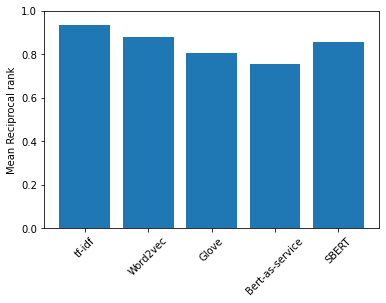

In [50]:
import matplotlib.pyplot as plt

plt.bar(mrr_df["vectorization_method"],mrr_df["mean_reciprocal_ranks"])
plt.ylabel("Mean Reciprocal rank")
plt.ylim(0,1)
plt.xticks(rotation = 45)